Rock - Paper - Scissors CNN Classifier

In [47]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten,Input, Conv2D, MaxPooling2D

In [48]:
seed = 17
image_size = (200, 300)
batch_size = 710
classes = ("paper", "rock", "scissors")
validation_split = 0.2

Preprocessing
Explore the dataset thoroughly and provide a summary of your observations.
Perform necessary preprocessing steps:
    - [x] Explore and plot the data
    - [x] Image resizing.
    - [x] Image normalization.
    - [x] Optionally, data augmentation techniques.
    - [x] Splitting the data into training and test sets appropriately.

In [49]:
initial_train_ds = tf.keras.utils.image_dataset_from_directory(
    "data_reconstructed/train",
    image_size=image_size,
    shuffle=True,
    seed=seed,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "data_reconstructed/validation",
    image_size=image_size,
    shuffle=False,
    seed=seed,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "data_reconstructed/test",
    image_size=image_size,
    shuffle=False,
    seed=seed,
)

Found 1531 files belonging to 3 classes.
Found 437 files belonging to 3 classes.
Found 220 files belonging to 3 classes.


In [50]:
def visualize_dataset(train_ds, classes):
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(16):
            plt.subplot(4, 4, i + 1)
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(classes[int(labels[i])])
            plt.axis("off")

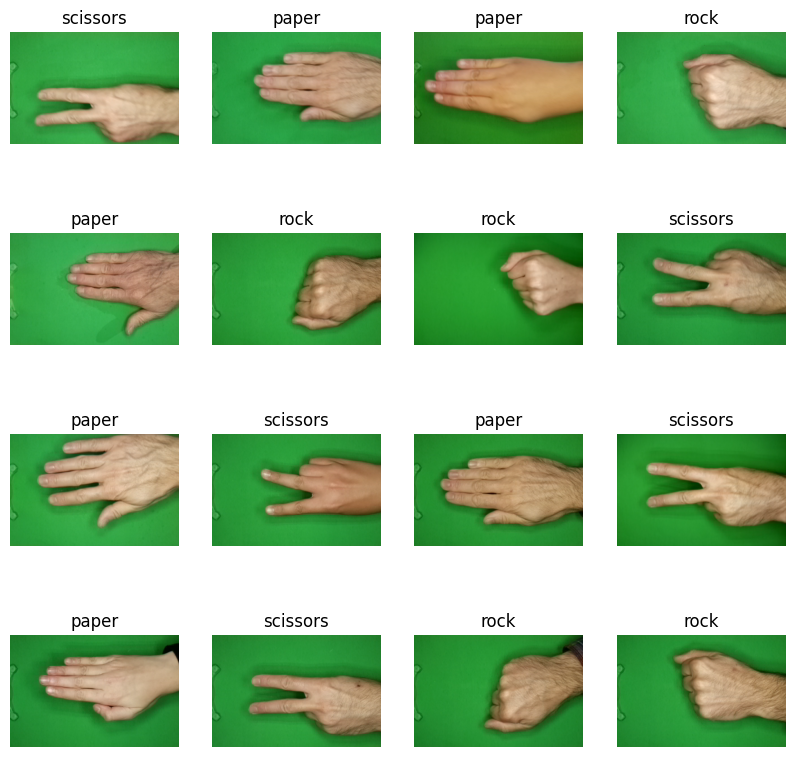

In [51]:
visualize_dataset(initial_train_ds, classes)

In [52]:
# data augmentation
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomBrightness(0.2, seed=seed),
    layers.RandomZoom(0.2, seed=seed),
    layers.RandomContrast(0.4, seed=seed),
    layers.RandomCrop(height=200, width=300, seed=seed),
])

augmented_train_ds = initial_train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


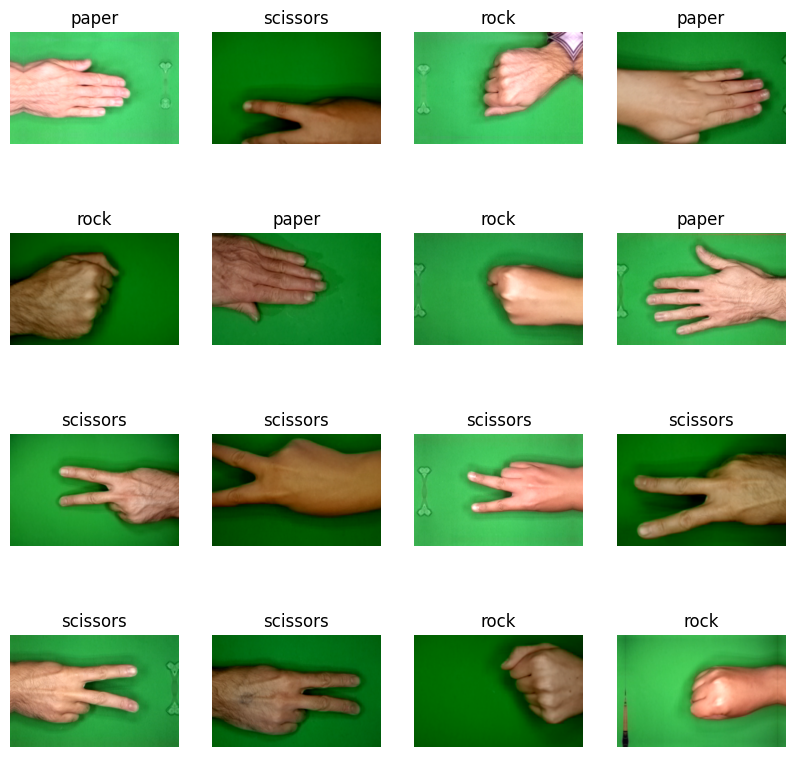

In [53]:
visualize_dataset(augmented_train_ds, classes)

### Image normalization.

In [54]:
# normalization
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = augmented_train_ds.map(normalize)
val_ds = val_ds.map(normalize)
test_ds = test_ds.map(normalize)

In [55]:
# convert datasets to numpy arrays for further processing
def dataset_to_numpy(ds):
    X, y = [], []
    for images, labels in ds:
        X.append(images.numpy())
        y.append(labels.numpy())
    return tf.concat(X, axis=0), tf.concat(y, axis=0)

X_train, y_train = dataset_to_numpy(train_ds)
X_validation, y_validation = dataset_to_numpy(val_ds)
X_test, y_test = dataset_to_numpy(test_ds)

2025-07-13 18:46:06.323906: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [56]:
X_train, y_train = dataset_to_numpy(train_ds)
X_validation, y_validation = dataset_to_numpy(val_ds)
X_test, y_test = dataset_to_numpy(test_ds)

In [57]:
# are the datasets balanced?
print(np.unique(y_train,return_counts=True),np.unique(y_validation,return_counts=True))

(array([0, 1, 2], dtype=int32), array([498, 508, 525])) (array([0, 1, 2], dtype=int32), array([142, 145, 150]))


The dataset is not imbalanced since the differences between the occurance of classes is not big.

Simple model
- one convolutional layer, 32 fiters 3x3 grid
- maxpooling 2x2
- hidden layer NN with 512 neurons
- softmax

In [58]:
def build_simple_model(hp):
    model = Sequential()
    model.add(Input(shape=(200, 300, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Conv2D(
        filters=hp.Int('conv_filters', min_value=32, max_value=128, step=32),
        kernel_size=3,
        activation='relu',
    ))
    model.add(MaxPooling2D(2, 2))
    model.add(Flatten())
    model.add(Dense( 
        units = hp.Int('dense_units', min_value=128, max_value=512, step=128), 
        activation='relu'))
    model.add(Dense(units=3, activation='softmax'))
    
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4], default=1e-3)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

### Tuning the model
Tuning params
 - Number of filters for the Convolutional Layer
 - Number of units for the densely-connected NN layer
 - Learning rate for the Optimizer

In [59]:
import keras_tuner as kt

tuner = kt.Hyperband(
    build_simple_model,
    objective='val_accuracy',
    max_epochs=5,
    max_retries_per_trial=0,
    executions_per_trial=1,
    directory='tuning_results',
    project_name='cnn_tuning'
)


Reloading Tuner from tuning_results/cnn_tuning/tuner0.json


In [60]:

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

tuner.search(train_ds, validation_data=val_ds, epochs=10, callbacks=[stop_early])


Search: Running Trial #9

Value             |Best Value So Far |Hyperparameter
96                |64                |conv_filters
512               |512               |dense_units
0.01              |0.0001            |learning_rate
5                 |5                 |tuner/epochs
0                 |2                 |tuner/initial_epoch
0                 |1                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/5
 2/48 ━━━━━━━━━━━━━━━━━━━━ 12:42 17s/step - accuracy: 0.4453 - loss: 475.1748

KeyboardInterrupt: 

In [ ]:
best_model_1 = tuner.get_best_models(num_models=1)[0]
best_hyperparams = tuner.get_best_hyperparameters(1)[0]
best_learning_rate = best_hyperparams.get('learning_rate')

print("Best Conv filters:", best_hyperparams.get('conv_filters'))
print("Best Dense units:", best_hyperparams.get('dense_units'))
print("Best Learning rate:", best_hyperparams.get('learning_rate'))

best_model_1.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best Conv filters: 64
Best Dense units: 512
Best Learning rate: 0.0001


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 196, 296, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 98, 148, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 928256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   475,267,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 475,288,515 (1.77 GB)

 Trainable params: 475,288,515 (1.77 GB)

 Non-trainable params: 0 (0.00 B)

### Used tuned params 

In [ ]:
best_model_1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
best_model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 196, 296, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 98, 148, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 928256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   475,267,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 475,288,515 (1.77 GB)

 Trainable params: 475,288,515 (1.77 GB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
best_model_1.fit(
    X_train,
    y_train,
    validation_data=(X_validation, y_validation),
    epochs=10,
    batch_size=32
)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 339s 7s/step - accuracy: 0.8033 - loss: 0.4730 - val_accuracy: 0.3432 - val_loss: 1.2711
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 436s 9s/step - accuracy: 0.9296 - loss: 0.2827 - val_accuracy: 0.3432 - val_loss: 1.3192
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 405s 8s/step - accuracy: 0.9354 - loss: 0.2110 - val_accuracy: 0.3432 - val_loss: 1.4525
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 328s 7s/step - accuracy: 0.9565 - loss: 0.1714 - val_accuracy: 0.3432 - val_loss: 1.7189
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 361s 8s/step - accuracy: 0.9789 - loss: 0.1081 - val_accuracy: 0.3432 - val_loss: 1.8664
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 386s 8s/step - accuracy: 0.9881 - loss: 0.0764 - val_accuracy: 0.3432 - val_loss: 2.1005
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 389s 8s/step - accuracy: 0.9867 - loss: 0.0746 - val_accuracy: 0.3432 - val_loss: 2.1938
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 404s 8s/step - accuracy: 0.9928 - loss: 0.0457 - val_accuracy: 0.3432 - v

In [ ]:
real = np.argmax(y_test,axis=1)
model_saved = best_model_1
y_pred = model_saved.predict(X_test)
pred = np.argmax(y_pred,axis=1)
print(pred)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


### Provide visualizations of training curves (loss and accuracy)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def test_results(model, X_test, y_test, classes):
    y_pred_probs = model.predict(X_test)

    y_pred = np.argmax(y_pred_probs, axis=1)
    
    if y_test.ndim > 1:
        y_test_labels = np.argmax(y_test, axis=1)
    else:
        y_test_labels = y_test
    
    # plot_training_curves(model)
    # plot_confusion_matrix(np.argmax(y_test, axis=1), pred, classes)
    classification_report(y_test_labels, y_pred, classes, digits=6)

# plot training curves and confusion matrix
sns.set_theme(style="whitegrid")

model = best_model_1
print(model.summary())

test_results(model, X_test, y_test, classes)

# Save the model
model.save("rock_paper_scissors_simple_cnn.h5")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 196, 296, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 98, 148, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 928256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   475,267,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,425,865,547 (5.31 GB)

 Trainable params: 475,288,515 (1.77 GB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 950,577,032 (3.54 GB)

None
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step


TypeError: too many positional arguments